In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [61]:
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.metrics import accuracy_score
mnist = input_data.read_data_sets(".", one_hot = True)

Extracting .\train-images-idx3-ubyte.gz
Extracting .\train-labels-idx1-ubyte.gz
Extracting .\t10k-images-idx3-ubyte.gz
Extracting .\t10k-labels-idx1-ubyte.gz


In [4]:
trainimgs = mnist.train.images
trainlabels = mnist.train.labels
testimgs = mnist.test.images
testlabels = mnist.test.labels 


In [5]:
ntrain = trainimgs.shape[0]
ntest = testimgs.shape[0]
dim = trainimgs.shape[1]
nclasses = trainlabels.shape[1]

In [7]:
print("Train Images: ", trainimgs.shape)
print("Train Labels  ", trainlabels.shape)
print("Test Images:  " , testimgs.shape)
print("Test Labels:  ", testlabels.shape)

Train Images:  (55000, 784)
Train Labels   (55000, 10)
Test Images:   (10000, 784)
Test Labels:   (10000, 10)


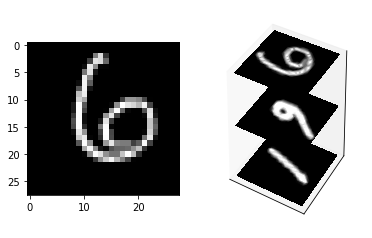

Sample: 100 - Class: [6] - Label Vector: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.] 
Sample: 1000 - Class: [9] - Label Vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.] 
Sample: 7000 - Class: [1] - Label Vector: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.] 


In [26]:
samplesIdx = [100, 1000,7000]
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow(testimgs[samplesIdx[0]].reshape([28,28]), cmap='gray')


xx, yy = np.meshgrid(np.linspace(0,28,28), np.linspace(0,28,28))
X =  xx ; Y =  yy
Z =  100*np.ones(X.shape)

img = testimgs[77].reshape([28,28])
ax = fig.add_subplot(122, projection='3d')
ax.set_zlim((0,200))


offset=200
for i in samplesIdx:
    img = testimgs[i].reshape([28,28]).transpose()
    ax.contourf(X, Y, img, 200, zdir='z', offset=offset, cmap="gray")
    offset -= 100

    ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()


for i in samplesIdx:
    print("Sample: {0} - Class: {1} - Label Vector: {2} ".format(i, np.nonzero(testlabels[i])[0], testlabels[i]))



# Our simple RNN consists of 


1. One input layer which converts a  28∗28  dimensional input to an  128  dimensional hidden layer,
2. One intermediate recurrent neural network (LSTM)
3. One output layer which converts an  128  dimensional output of the LSTM to  10  dimensional output indicating a class label.

In [27]:
n_input = 28 # mnist data input 
n_steps = 28 # timesteps 
n_hidden = 128 # hidden layer num of features
n_classes = 10 # mnist total classes 

learning_rate = 0.001
training_iters = 100000
batch_size = 100
display_step = 10

# Construct a Recurrent Neural Network  

the input should be a tensor of shape: [batch_size, time_steps, input_dimension], but in our case it would be (?, 28,28)


In [28]:
x = tf.placeholder(dtype="float", shape = [None,n_steps, n_input], name = "x")
y = tf.placeholder(dtype="float", shape = [None, n_classes], name = "y")

In [31]:
#lets create the weights and bias 
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden,n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [32]:
print(weights, biases)

{'out': <tf.Variable 'Variable:0' shape=(128, 10) dtype=float32_ref>} {'out': <tf.Variable 'Variable_1:0' shape=(10,) dtype=float32_ref>}


In [35]:
# lets define a lstm cell with tensorflow
lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias = 1.0)

In [36]:
# dynamic_rnn create a RNN specified from lstm_cell
outputs, states = tf.nn.dynamic_rnn(lstm_cell, inputs= x, dtype= tf.float32)

In [37]:
#The output of the rnn would be a [100x28x128] matrix. we use the linear activation to map it to a [?x10 matrix]
output = tf.reshape(tf.split(outputs, 28, axis=1, num=None, name='split')[-1],[-1,128])
pred = tf.matmul(output, weights['out']) + biases['out']

In [38]:
pred

<tf.Tensor 'add:0' shape=(?, 10) dtype=float32>

In [43]:
## now we have to define the cost and optimizer fucntions 
cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = pred))
optimizer =  tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(cost)
print(cost, optimizer)

Tensor("Mean_4:0", shape=(), dtype=float32) name: "Adam_1"
op: "NoOp"
input: "^Adam_1/update_Variable/ApplyAdam"
input: "^Adam_1/update_Variable_1/ApplyAdam"
input: "^Adam_1/update_rnn/basic_lstm_cell/kernel/ApplyAdam"
input: "^Adam_1/update_rnn/basic_lstm_cell/bias/ApplyAdam"
input: "^Adam_1/Assign"
input: "^Adam_1/Assign_1"



In [66]:
# here we define the accuracy and evalution methods to be used in the learning process
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
print(correct_pred, accuarcy)

Tensor("Equal_2:0", shape=(?,), dtype=bool) Tensor("Mean_6:0", shape=(), dtype=float32)


In [67]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:

        # We will read a batch of 100 images [100 x 784] as batch_x
        # batch_y is a matrix of [100x10]
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # We consider each row of the image as one sequence
        # Reshape data to get 28 seq of 28 elements, so that, batxh_x is [100x28x28]
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
    

        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Iter 1000, Minibatch Loss= 1.789908, Training Accuracy= 0.33000
Iter 2000, Minibatch Loss= 1.648392, Training Accuracy= 0.47000
Iter 3000, Minibatch Loss= 1.304311, Training Accuracy= 0.51000
Iter 4000, Minibatch Loss= 0.908350, Training Accuracy= 0.65000
Iter 5000, Minibatch Loss= 0.880291, Training Accuracy= 0.74000
Iter 6000, Minibatch Loss= 0.740380, Training Accuracy= 0.75000
Iter 7000, Minibatch Loss= 0.505338, Training Accuracy= 0.85000
Iter 8000, Minibatch Loss= 0.415196, Training Accuracy= 0.87000
Iter 9000, Minibatch Loss= 0.587057, Training Accuracy= 0.75000
Iter 10000, Minibatch Loss= 0.547915, Training Accuracy= 0.87000
Iter 11000, Minibatch Loss= 0.372272, Training Accuracy= 0.88000
Iter 12000, Minibatch Loss= 0.646169, Training Accuracy= 0.86000
Iter 13000, Minibatch Loss= 0.353479, Training Accuracy= 0.91000
Iter 14000, Minibatch Loss= 0.329699, Training Accuracy= 0.88000
Iter 15000, Minibatch Loss= 0.293527, Training Accuracy= 0.89000
Iter 16000, Minibatch Loss= 0.3478

In [68]:
sess.close()